In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(rvest)
install.packages("GGally")
library("GGally")
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [3]:
shoppers_data_full <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv")
shoppers_data_full

Parsed with column specification:
cols(
  Administrative = col_double(),
  Administrative_Duration = col_double(),
  Informational = col_double(),
  Informational_Duration = col_double(),
  ProductRelated = col_double(),
  ProductRelated_Duration = col_double(),
  BounceRates = col_double(),
  ExitRates = col_double(),
  PageValues = col_double(),
  SpecialDay = col_double(),
  Month = col_character(),
  OperatingSystems = col_double(),
  Browser = col_double(),
  Region = col_double(),
  TrafficType = col_double(),
  VisitorType = col_character(),
  Weekend = col_logical(),
  Revenue = col_logical()
)



Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<lgl>
0,0,0,0,1,0,0.2,0.2,0,0,Feb,1,1,1,1,Returning_Visitor,FALSE,FALSE
0,0,0,0,2,64,0.0,0.1,0,0,Feb,2,2,1,2,Returning_Visitor,FALSE,FALSE
0,0,0,0,1,0,0.2,0.2,0,0,Feb,4,1,9,3,Returning_Visitor,FALSE,FALSE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,0,0,0,6,184.25,0.08333333,0.08666667,0,0,Nov,3,2,1,13,Returning_Visitor,TRUE,FALSE
4,75,0,0,15,346.00,0.00000000,0.02105263,0,0,Nov,2,2,3,11,Returning_Visitor,FALSE,FALSE
0,0,0,0,3,21.25,0.00000000,0.06666667,0,0,Nov,3,2,1,2,New_Visitor,TRUE,FALSE


In [22]:
set.seed(10)
shoppers_data <- shoppers_data_full %>% 
    select(ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,Revenue) %>% 
    mutate(Revenue = as_factor(Revenue))
shoppers_split <- initial_split(data = shoppers_data, prop = 0.75, strata = Revenue)
shoppers_training <- training(shoppers_split) 
shoppers_testing <- testing(shoppers_split)
shoppers_training

ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,Revenue
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,0,0.2,0.2,0,FALSE
2,64,0.0,0.1,0,FALSE
1,0,0.2,0.2,0,FALSE
⋮,⋮,⋮,⋮,⋮,⋮
5,465.75,0,0.02133333,0,FALSE
15,346.00,0,0.02105263,0,FALSE
3,21.25,0,0.06666667,0,FALSE


In [23]:

shoppers_recipe <- recipe(Revenue ~ ., data = shoppers_training) %>% 
     step_upsample(Revenue, over_ratio = 1, skip = TRUE) %>% 
     step_scale(all_predictors()) %>% 
     step_center(all_predictors()) 
#      prep() %>%
#      bake(shoppers_training)
# shoppers_recipe <- shoppers_recipe %>% 
#     step_scale(all_predictors()) %>% 
#      step_center(all_predictors())

# summary(shoppers_recipe$Revenue)
shoppers_recipe 


Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          5

Operations:

Up-sampling based on Revenue
Scaling for all_predictors()
Centering for all_predictors()

In [24]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
    set_engine("kknn") %>% 
    set_mode("classification")

shoppers_vfold <- vfold_cv(shoppers_training, v = 5, strata = Revenue)



In [25]:
shoppers_workflow <- workflow() %>% 
    add_recipe(shoppers_recipe) %>% 
    add_model(knn_spec) %>% 
    tune_grid(resamples = shoppers_vfold, grid = tibble(neighbors = seq(1,50,by = 5))) %>% 
    collect_metrics()
shoppers_workflow

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.8581326,5,0.003845619,Model01
1,roc_auc,binary,0.7313980,5,0.006885051,Model01
6,accuracy,binary,0.8115279,5,0.004167067,Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
41,roc_auc,binary,0.8812782,5,0.002888103,Model09
46,accuracy,binary,0.8423443,5,0.002527607,Model10
46,roc_auc,binary,0.8828790,5,0.002351624,Model10


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.8581326,5,0.003845619,Model01
6,accuracy,binary,0.8115279,5,0.004167067,Model02
11,accuracy,binary,0.7983353,5,0.002542368,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
36,accuracy,binary,0.8392087,5,0.002306337,Model08
41,accuracy,binary,0.8414800,5,0.002811737,Model09
46,accuracy,binary,0.8423443,5,0.002527607,Model10


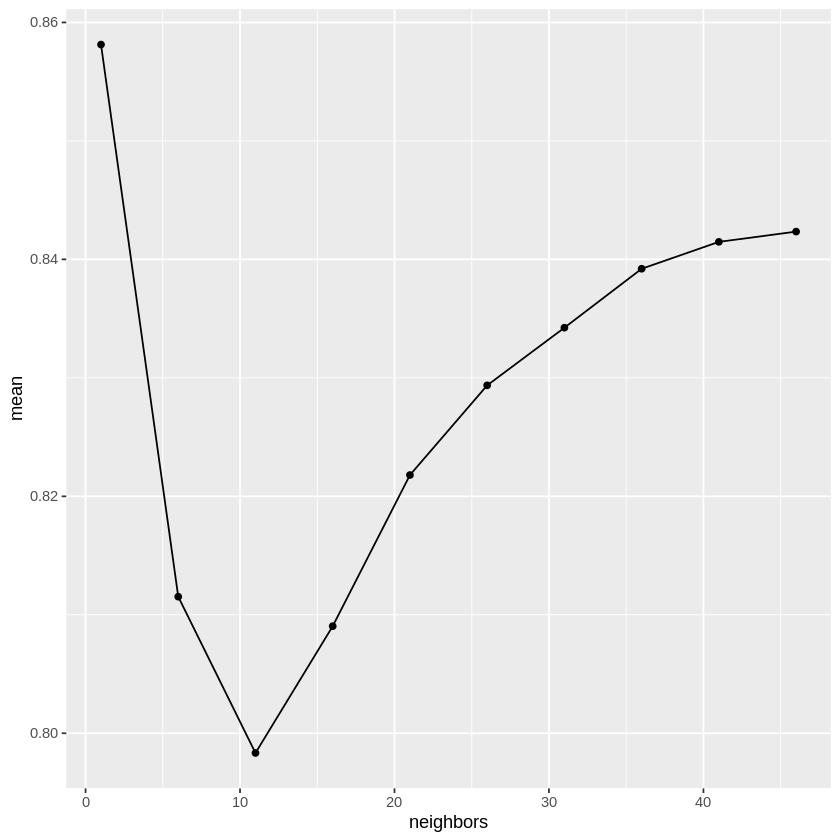

In [26]:
shoppers_accuracy <- shoppers_workflow %>% 
    filter(.metric == "accuracy")
shoppers_accuracy
shoppers_k <- shoppers_accuracy %>% 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_line()+
    geom_point()
shoppers_k